# Catalog

In [2]:
%matplotlib widget
import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely
import pystare
import numpy

ModuleNotFoundError: No module named 'ipympl'

## Loading countries
We load the countries of the world and create STARE index values representing their cover. 

In [9]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
n_america = world[world.continent=='North America']

stare = starepandas.sids_from_gdf(n_america, level=8, force_ccw=True)
n_america = starepandas.STAREDataFrame(n_america, sids=stare)

# The trixels are just for visualization
trixels = n_america.make_trixels()
n_america.set_trixels(trixels, inplace=True)
n_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids,trixels
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","[3035426148847714308, 3062447746611937284, 306...","MULTIPOLYGON (((-75.36119 57.63159, -70.81323 ..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...","[3332663724254167043, 3071454945866678276, 307...","MULTIPOLYGON (((-90.00000 35.26439, -101.10559..."
16,11263077.0,North America,Haiti,HTI,14332,"POLYGON ((-71.71236 19.71446, -71.62487 19.169...","[3100869080932941831, 3130283215999205383, 310...","MULTIPOLYGON (((-72.49081 19.13394, -72.09835 ..."
17,10738958.0,North America,Dominican Rep.,DOM,88941,"POLYGON ((-71.70830 18.04500, -71.68774 18.316...","[3130072109766672391, 3130107294138761223, 313...","MULTIPOLYGON (((-70.94437 18.60746, -70.17478 ..."
19,389482.0,North America,Bahamas,BHS,13578,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...","[3126113867906678792, 3128875841115652104, 312...","MULTIPOLYGON (((-78.19386 26.86535, -77.77602 ..."


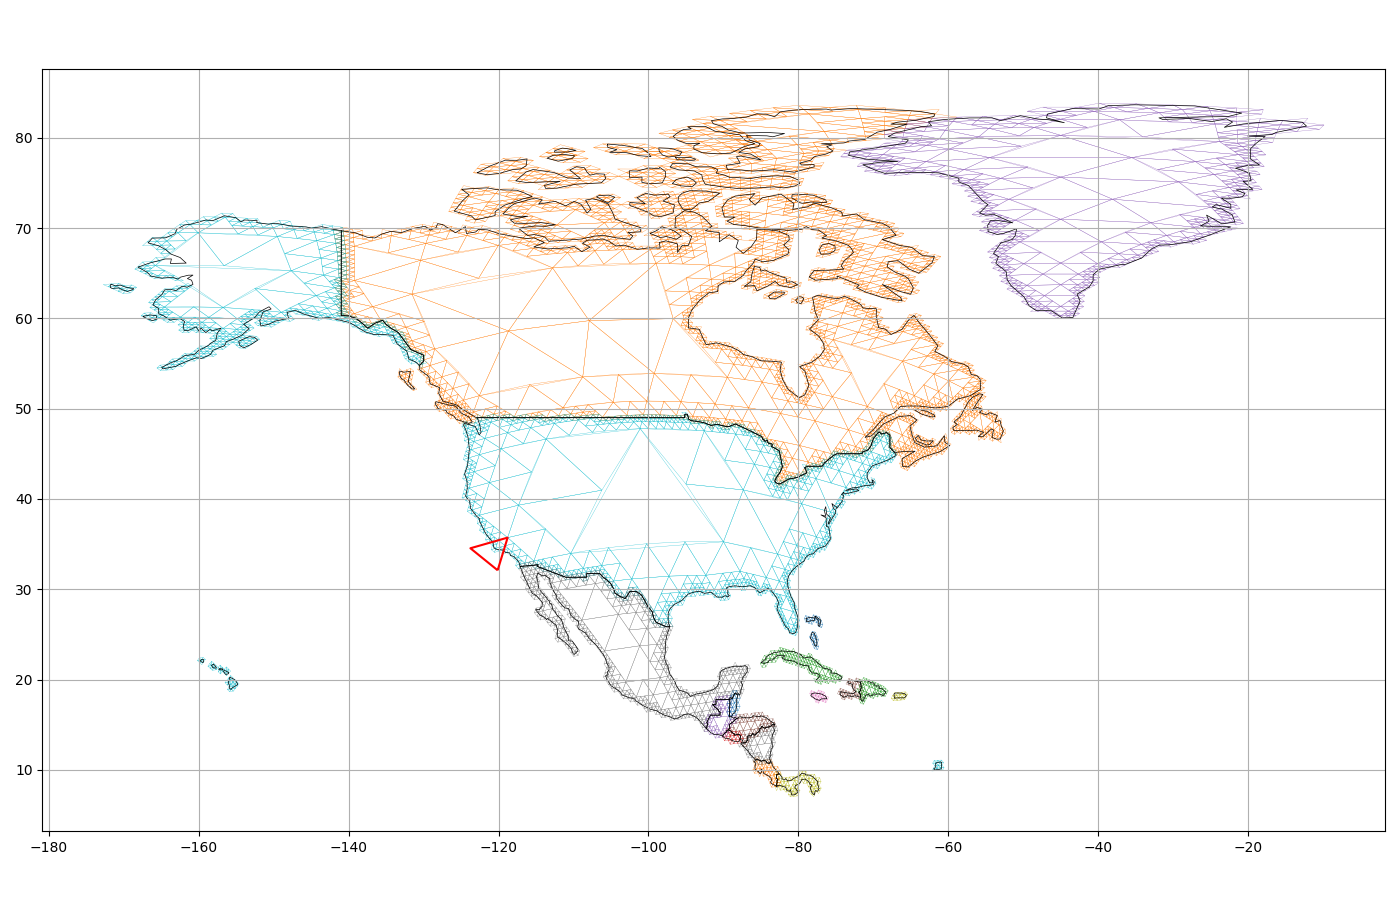

In [36]:
fig, ax = plt.subplots(dpi=100, figsize=(14,9))
ax.grid(True)

n_america.plot(ax=ax, trixels=True, boundary=True, column='name', zorder=0, linewidth=0.2)
n_america.plot(ax=ax, trixels=False, facecolor="none", edgecolor='black', zorder=1, linewidth=0.5)
santa_barbara_sid = pystare.from_lonlat([-119.81100397568609], [34.44687326105255], level=5)
santa_barbara = starepandas.STAREDataFrame(sids=santa_barbara_sid).add_trixels().plot(ax=ax, color='red')

fig.tight_layout()

#plt.savefig('n_america.png')

## We are creating a catalogue dataframe

folder2catalogue() scans the path for granules, reads stare cover from the sidecar file as well as the timestamps from the metadata and creatse a catalogue dataframe

In [4]:
folder = '../tests/data/catalog/'
catalog = starepandas.folder2catalog(path=folder, 
                                     granule_extension='hdf',
                                     add_sf=True)
catalog.add_trixels(inplace=True)

## Now we use the catalog to find all granules that intersect our ROI

<AxesSubplot:>

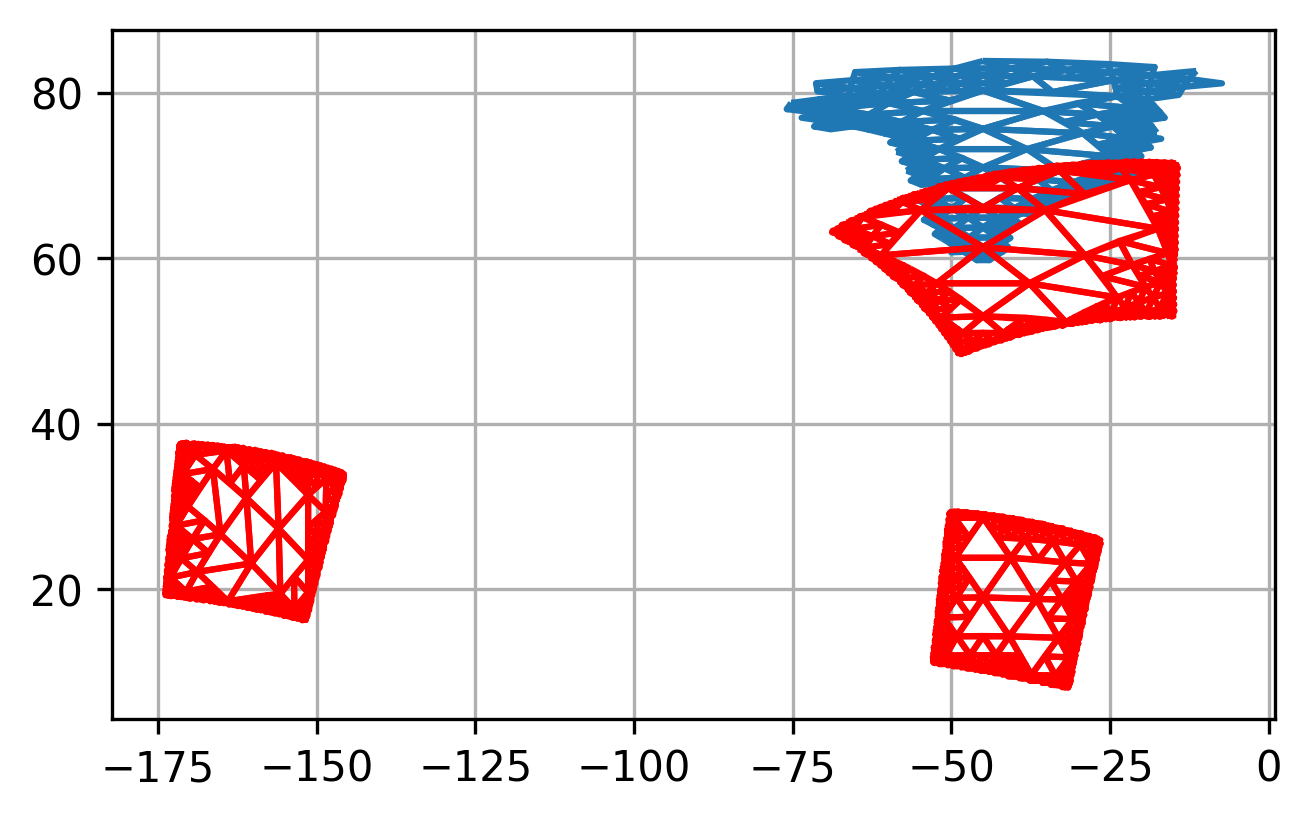

<Axes: >

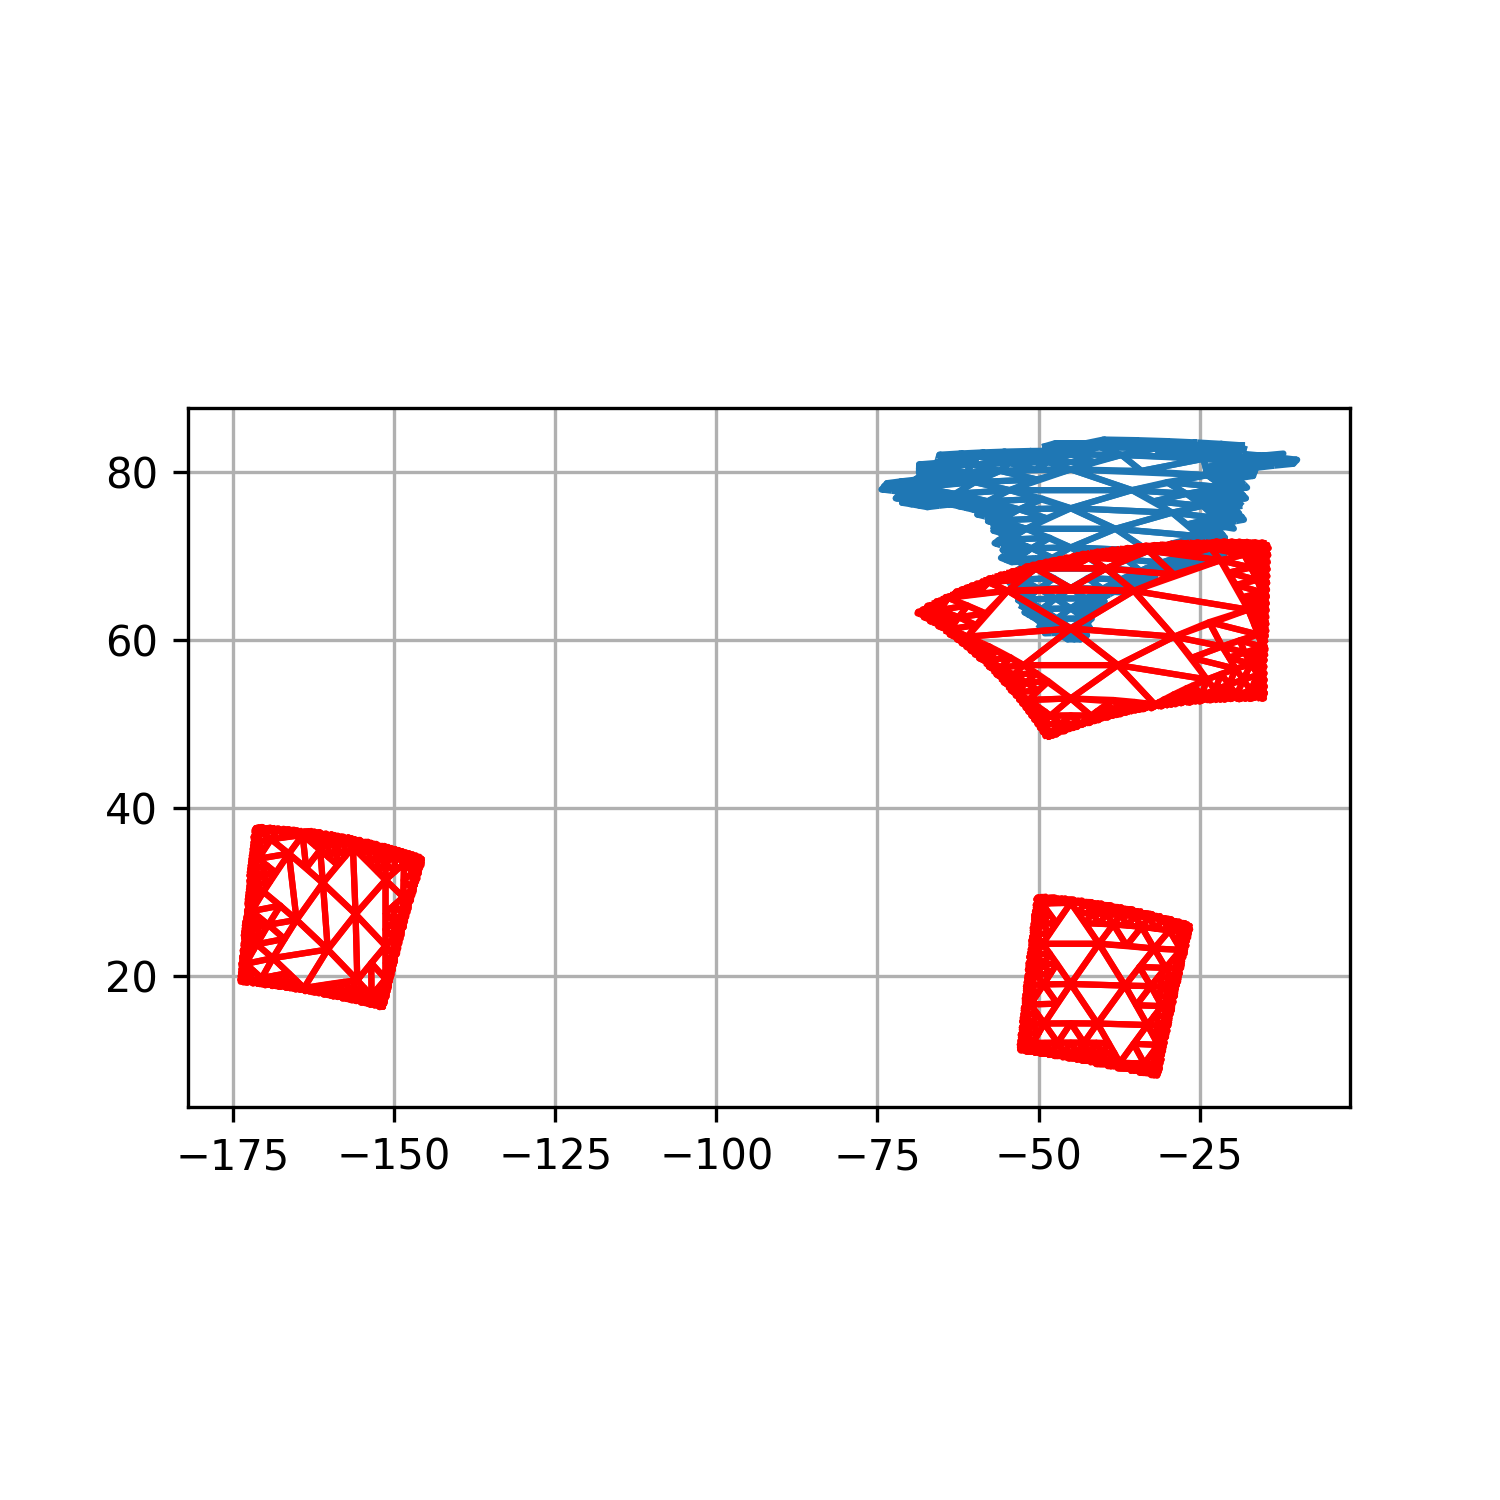

In [6]:
fig, ax = plt.subplots(dpi=300, figsize=(5,5))
ax.grid(True)

country = n_america[n_america.name=='Greenland']
country.plot(ax=ax)
catalog.plot(ax=ax, color='r')

### We can do this with geopandas SF based intersects method

In [6]:
roi_wkt = country.geometry.iloc[0]

cover_intersects = catalog.intersects(roi_wkt)
granule_subset = catalog[cover_intersects].granule_path
granule_subset.head()

0    ../tests/data/catalog/MOD05_L2.A2019336.0000.0...
Name: granule_path, dtype: object

### We can do this with stare_intersects

In [7]:
roi_stare = n_america[n_america.name=='Greenland']['sids'].iloc[0]

cover_intersects = catalog.stare_intersects(roi_stare)
granule_subset = catalog[cover_intersects].granule_path

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 1 granules intersecting the ROI


0    ../tests/data/catalog/MOD05_L2.A2019336.0000.0...
Name: granule_path, dtype: object

## Finally, we extract the data from the pre-selected granules that intersects with our ROI

In [8]:
df = pandas.DataFrame()
for granule in granule_subset:
    g = starepandas.read_granule(granule, sidecar=True)
    
    intersects = g.stare_intersects(roi_stare)
    msg = '{granule} has {n} intersecting points'.format(granule=granule,
                                                        n=sum(intersects))
    
    print(msg)
    df = pandas.concat([pandas.DataFrame(g)[intersects]])

../tests/data/catalog/MOD05_L2.A2019336.0000.061.2019336211522.hdf has 26756 intersecting points


In [9]:
df.head()

,sids,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared
55278,3630376560299884459,8.493986e+08,132.559997,-55.049999,28.639999,67.659998,NaN
55279,3630376364319331947,8.493986e+08,132.529997,-55.179999,29.099999,67.569998,0.161
55280,3630446998470491531,8.493986e+08,132.489997,-55.319999,29.569999,67.479998,0.166
55546,3630379610335789163,8.493986e+08,132.579997,-54.779999,27.709999,68.769998,0.395
55547,3630377324249826827,8.493986e+08,132.549997,-54.909999,28.169999,68.669998,NaN


## Write to SQL 
We can write the catalogue dataframe to an sql (e.g. sqlite) database. 
From here, we could use STARELite to query the catalogue, or load it back into a STAREDataframe if we need to

In [11]:
catalog

,granule_path,sidecar_path,stare_cover,begining,ending,geom,trixels
0,../tests/data/catalog/MOD05_L2.A2019336.0000.0...,../tests/data/catalog/MOD05_L2.A2019336.0000.0...,"[3604075970547417096, 3604089164686950409, 360...",2019-12-02 00:00:00,2019-12-02 00:05:00,"POLYGON ((-15.93400 53.20178, -15.93275 53.292...","MULTIPOLYGON (((-45.00000 61.32495, -37.69296 ..."
1,../tests/data/catalog/MOD05_L2.A2005349.2125.0...,../tests/data/catalog/MOD05_L2.A2005349.2125.0...,"[864691128455135238, 864867050315579401, 86486...",2005-12-15 21:25:00,2005-12-15 21:30:00,"POLYGON ((-171.02278 37.52311, -171.02644 37.4...","MULTIPOLYGON (((-160.28950 23.13179, -165.1269..."
2,../tests/data/catalog/MOD05_L2.A2020254.1320.0...,../tests/data/catalog/MOD05_L2.A2020254.1320.0...,"[2461217196357976072, 2461228191474253833, 246...",2020-09-10 13:20:00,2020-09-10 13:25:00,"POLYGON ((-49.78107 29.28507, -49.78662 29.195...","MULTIPOLYGON (((-36.58975 18.83358, -40.88022 ..."


In [12]:
db_path = '' # Empty for in-memory
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)

catalog_ewkb = geopandas.io.sql._convert_to_ewkb(catalog, 'geom', 4326)
catalog[['granule_path', 'sidecar_path', 'stare_cover', 'begining', 'ending', 'geom']].to_sql(name='catalog', con=engine, if_exists='replace', index=False)

3

## Load from SQL

In [15]:
cover_intersects = pandas.read_sql(sql='catalog', con=engine)

# Geometry and STARE are stored in blobs, so we need to deserialize
cover_intersects.stare_cover = cover_intersects.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
cover_intersects.geom = cover_intersects.geom.apply(shapely.wkb.loads, args=(True,))

# We convert the conventional DF to a STAREDataFrame and set the stare column
cover_intersects = starepandas.STAREDataFrame(cover_intersects, sids='stare_cover')


AttributeError: 'OptionEngine' object has no attribute 'execute'